## Сделать классификацию данных fakenews

Используя ноутбук занятия (также размещен в папке Materials) и данные fakenews, 3 раза разными способами получить на задаче классификации значение f1 выше 0.91 для методов на sklearn и выше 0.52 для методов на pytorch.

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier

from sklearn.metrics import classification_report
import xgboost as xgb

In [ ]:
!wget https://raw.githubusercontent.com/diptamath/covid_fake_news/main/data/Constraint_Train.csv

--2023-04-11 16:48:09--  https://raw.githubusercontent.com/diptamath/covid_fake_news/main/data/Constraint_Train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1253562 (1.2M) [text/plain]
Saving to: ‘Constraint_Train.csv’

Constraint_Train.cs 100%[===================>]   1.20M  --.-KB/s    in 0.01s   

2023-04-11 16:48:10 (117 MB/s) - ‘Constraint_Train.csv’ saved [1253562/1253562]



In [ ]:
df = pd.read_csv('Constraint_Train.csv')

In [ ]:
df.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


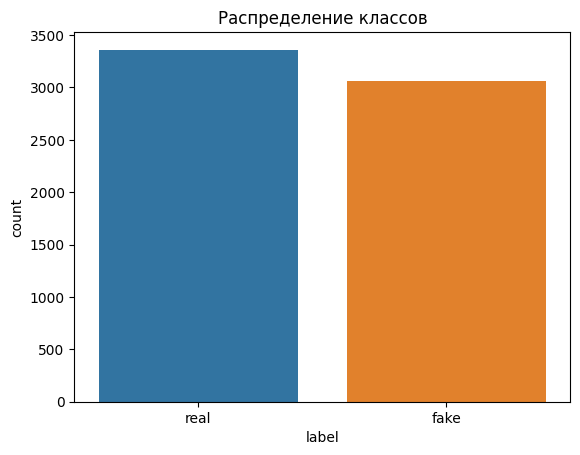

In [ ]:
sns.countplot(x='label', data=df, order=df['label'].value_counts().index)
plt.title('Распределение классов')
plt.show();

## Сделаем некоторую предобработку текста

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
stopwords_set = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
words = re.compile('[a-zA-Z]+')


def words_only(text):
    return ' '.join(words.findall(text))


def lemmatize(text):
    try:
        return ' '.join([lemmatizer.lemmatize(t) for t in text.lower().split()])
    except:
        return ' '
    
    
def remove_stopwords(text, stop_words=stopwords_set):
    try:
        return ' '.join([token for token in text.split() if token not in stop_words])
    except:
        return ' '
    
def preprocess(text):
    return remove_stopwords(lemmatize(words_only(text.lower())))

In [ ]:
df['tweet'] = df['tweet'].astype('str').apply(preprocess)

In [ ]:
df.head()

,id,tweet,label
0,1,cdc currently report death general discrepancy...,real
1,2,state reported death small rise last tuesday s...,real
2,3,politically correct woman almost us pandemic e...,fake
3,4,indiafightscorona covid testing laboratory ind...,real
4,5,populous state generate large case count look ...,real


In [ ]:
from gensim.models import Word2Vec

In [ ]:
sentence = [word_tokenize(text) for text in df['tweet']]

In [ ]:
model_w2v = Word2Vec(sentences = sentence, workers = 4, min_count = 3, vector_size = 250, window = 5)

In [ ]:
model_w2v.init_sims()

<ipython-input-13-07fe08bfe0b4>:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model_w2v.init_sims()


In [ ]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
df.head()

,id,tweet,label
0,1,cdc currently report death general discrepancy...,1
1,2,state reported death small rise last tuesday s...,1
2,3,politically correct woman almost us pandemic e...,0
3,4,indiafightscorona covid testing laboratory ind...,1
4,5,populous state generate large case count look ...,1


In [ ]:
def get_text_embedding(text):
    result = []
    for word in word_tokenize(text.lower()):
        if word in model_w2v.wv:
            result.append(model_w2v.wv[word])

    if len(result):
        result = np.sum(result, axis=0)
    else:
        result = np.zeros(300)
    return result

In [ ]:
features = [get_text_embedding(text) for text in df['tweet']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, df['label'], test_size=0.2, random_state=42)

## Support func()

In [ ]:
def grid_classifier_params(algo, params, features=features, labels=df['label']):
  X_train, X_test, y_train, y_test = train_test_split(features, df['label'], test_size=0.2, random_state=42)
  scaler = StandardScaler()
  pipe = Pipeline(steps=[('scaler', scaler), ('algo', algo)])
  search = GridSearchCV(pipe, params, n_jobs=2)
  search.fit(X_train, y_train)
  return search.best_params_

## Try search best params for algoritms

In [ ]:
logreg = LogisticRegression()
knc = KNeighborsClassifier()
svc = SVC()
dtc = DecisionTreeClassifier()
lda = LinearDiscriminantAnalysis()
rfc = RandomForestClassifier()

In [ ]:
parameters_logreg = {'algo__penalty': ['l1', 'l2', 'elasticnet', None],
                     'algo__C':[1, 10],
                     'algo__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}

parameters_knc = {'algo__n_neighbors': [5, 10, 15, 20, 25]}

parameters_svc = {'algo__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
                  'algo__gamma': ['scale', 'auto']}

parameters_dtc = {'algo__criterion': ['gini', 'entropy', 'log_loss'],
                  'algo__max_depth': [5, 10, 15, 20, 25]}

parameters_lda = {'algo__solver': ['svd', 'lsqr', 'eigen']}

parameters_rfc = {'algo__n_estimators': [30, 50, 100, 150, 200, 300, 500],
                  'algo__criterion': ['gini', 'entropy', 'log_loss'],
                  'algo__max_depth': [5, 10, 15, 20, 25]}

In [ ]:
print(grid_classifier_params(logreg, parameters_logreg, features=features, labels=df['label']))

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
110 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  F

{'algo__C': 1, 'algo__penalty': None, 'algo__solver': 'newton-cg'}


In [ ]:
lg = LogisticRegression(C=1, penalty=None, solver= 'newton-cg')
lg.fit(X_train, y_train)
print(classification_report(y_test, lg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.90      0.89       596
           1       0.91      0.88      0.90       688

    accuracy                           0.89      1284
   macro avg       0.89      0.89      0.89      1284
weighted avg       0.89      0.89      0.89      1284



/usr/local/lib/python3.9/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


In [ ]:
print(grid_classifier_params(knc, parameters_knc, features=features, labels=df['label']))

{'algo__n_neighbors': 20}


In [ ]:
knc = KNeighborsClassifier(n_neighbors=20)
knc.fit(X_train, y_train)
print(classification_report(y_test, knc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.82      0.80       596
           1       0.83      0.81      0.82       688

    accuracy                           0.81      1284
   macro avg       0.81      0.81      0.81      1284
weighted avg       0.81      0.81      0.81      1284



In [ ]:
print(grid_classifier_params(svc, parameters_svc, features=features, labels=df['label']))

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py", line 217, in fit
    raise ValueError(
ValueError: Precomputed matrix must be a square matrix. Input i

{'algo__gamma': 'scale', 'algo__kernel': 'linear'}


In [ ]:
svc = SVC(gamma= 'scale', kernel= 'linear')
svc.fit(X_train, y_train)
print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       596
           1       0.90      0.87      0.88       688

    accuracy                           0.87      1284
   macro avg       0.87      0.88      0.87      1284
weighted avg       0.88      0.87      0.87      1284



In [ ]:
print(grid_classifier_params(dtc, parameters_dtc, features=features, labels=df['label']))

{'algo__criterion': 'log_loss', 'algo__max_depth': 5}


In [ ]:
dtc = DecisionTreeClassifier(criterion='log_loss', max_depth=5)
dtc.fit(X_train, y_train)
print(classification_report(y_test, dtc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.73      0.89      0.81       596
           1       0.89      0.72      0.79       688

    accuracy                           0.80      1284
   macro avg       0.81      0.81      0.80      1284
weighted avg       0.82      0.80      0.80      1284



In [ ]:
print(grid_classifier_params(lda, parameters_lda, features=features, labels=df['label']))

{'algo__solver': 'svd'}


In [ ]:
lda = LinearDiscriminantAnalysis(solver='svd')
lda.fit(X_train, y_train)
print(classification_report(y_test, lda.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.90      0.88       596
           1       0.91      0.86      0.89       688

    accuracy                           0.88      1284
   macro avg       0.88      0.88      0.88      1284
weighted avg       0.88      0.88      0.88      1284



In [ ]:
print(grid_classifier_params(rfc, parameters_rfc, features=features, labels=df['label']))

{'algo__criterion': 'log_loss', 'algo__max_depth': 25, 'algo__n_estimators': 500}


In [ ]:
rfc = RandomForestClassifier(n_estimators=800, criterion='log_loss', max_depth=35)
rfc.fit(X_train, y_train)
print(classification_report(y_test, rfc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       596
           1       0.85      0.85      0.85       688

    accuracy                           0.84      1284
   macro avg       0.83      0.83      0.83      1284
weighted avg       0.84      0.84      0.84      1284



In [ ]:
from sklearn.pipeline import make_pipeline

In [ ]:
estimators = [
     ('lr', make_pipeline(StandardScaler(), LogisticRegression(C=1, penalty=None, solver= 'newton-cg'))),
     ('rf', make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=800, criterion='log_loss', max_depth=35))),
     ('knc', make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=20))),
     ('svc', make_pipeline(StandardScaler(), SVC(gamma= 'scale', kernel= 'linear'))),
     ('dtc', make_pipeline(StandardScaler(), DecisionTreeClassifier(criterion='log_loss', max_depth=5))),
]

In [ ]:
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

In [ ]:
clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       596
           1       0.91      0.89      0.90       688

    accuracy                           0.89      1284
   macro avg       0.89      0.89      0.89      1284
weighted avg       0.89      0.89      0.89      1284



In [ ]:
PARAMETERS = {"subsample":[0.75, 1],
              "colsample_bytree":[0.75, 1],
              "max_depth":[2, 6],
              "min_child_weight":[1, 5],
              "learning_rate":[0.1, 0.01]}

clf_x = xgb.XGBClassifier(n_estimators=100, n_jobs=-1, eval_metric='logloss')


model_x = GridSearchCV(estimator=clf_x,
                       param_grid=PARAMETERS,
                       cv=3)

model_x.fit(X_train, y_train)
print(model_x.best_params_)

{'colsample_bytree': 0.75, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 1}


In [ ]:
clf_x = xgb.XGBClassifier(n_estimators=100, n_jobs=-1, eval_metric='logloss', colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, subsample=1)
clf_x.fit(X_train, y_train)
print(classification_report(y_test, clf_x.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83       596
           1       0.84      0.87      0.86       688

    accuracy                           0.85      1284
   macro avg       0.85      0.84      0.84      1284
weighted avg       0.85      0.85      0.84      1284



## TfidfVectorizer

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['tweet'], df['label'], test_size=0.20, random_state=42)
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_train_x = vectorizer.fit_transform(X_train)
tfidf_test_x = vectorizer.transform(X_test)
lg = LogisticRegression(C=1, penalty=None, solver= 'newton-cg')
lg.fit(tfidf_train_x, y_train)
print(classification_report(y_test, lg.predict(tfidf_test_x)))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       596
           1       0.93      0.94      0.93       688

    accuracy                           0.93      1284
   macro avg       0.93      0.93      0.93      1284
weighted avg       0.93      0.93      0.93      1284



In [ ]:
estimators_x = [
     ('lr', LogisticRegression(C=1, penalty=None, solver= 'newton-cg')),
     ('rf', RandomForestClassifier(n_estimators=800, criterion='log_loss', max_depth=35)),
     ('knc', KNeighborsClassifier(n_neighbors=20)),
     ('svc', SVC(gamma= 'scale', kernel= 'linear')),
     ('dtc', DecisionTreeClassifier(criterion='log_loss', max_depth=5)),
]

In [ ]:
clf_1 = StackingClassifier(estimators=estimators_x, final_estimator=LogisticRegression())

In [ ]:
clf_1.fit(tfidf_train_x, y_train)
print(classification_report(y_test, clf_1.predict(tfidf_test_x)))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93       596
           1       0.93      0.94      0.94       688

    accuracy                           0.93      1284
   macro avg       0.93      0.93      0.93      1284
weighted avg       0.93      0.93      0.93      1284



### В целом нужное качество получено 93% на, по сути, обычной логичстической регрессии и ftidf векторах.

## Torch

In [ ]:
labels = (df.label == 1).astype(int).to_list()

In [ ]:
token_lists = [word_tokenize(text.lower()) for text in df.tweet]
max_len = len(max(token_lists, key=len))

In [ ]:
from collections import Counter
fd = Counter([len(tokens) for tokens in token_lists])
fd.most_common(10)

[(15, 317),
 (14, 313),
 (13, 312),
 (16, 282),
 (12, 275),
 (11, 251),
 (10, 247),
 (26, 243),
 (9, 238),
 (17, 231)]

In [ ]:
def get_word_embedding(tokens, max_len):
    result = []
    for i in range(max_len):
        if i < len(tokens):
            word = tokens[i]
            if word in model_w2v.wv:
                result.append(model_w2v.wv[word])
            else:
                result.append(np.zeros(250))
        else:
            result.append(np.zeros(250))
    return result

In [ ]:
features = [get_word_embedding(text, 250) for text in token_lists]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__()
    self.lstm = nn.LSTM(250, 100)
    self.out = nn.Linear(100, 1)

  def forward(self, x):
    embeddings, (shortterm, longterm) = self.lstm(x.transpose(0, 1))
    prediction = torch.sigmoid(self.out(longterm))
    return prediction


net = Net()
print(net)

Net(
  (lstm): LSTM(250, 100)
  (out): Linear(in_features=100, out_features=1, bias=True)
)


In [ ]:
in_data = torch.tensor(X_train).float()
targets = torch.tensor(y_train).float()

<ipython-input-23-02003c1debcb>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  in_data = torch.tensor(X_train).float()


In [ ]:
optimizer = optim.Adam(net.parameters(), lr=0.01)
loss_func = nn.BCELoss()

In [ ]:
from tqdm import tqdm


def train_one_epoch(in_data=in_data, targets=targets, batch_size=16):
  for i in tqdm(range(0, in_data.shape[0], batch_size)):
    batch_x = in_data[i:i + batch_size]
    batch_y = targets[i:i + batch_size]
    optimizer.zero_grad()
    output = net(batch_x)
    loss = loss_func(output.reshape(-1), batch_y)
    loss.backward()
    optimizer.step()
  print(loss)

In [ ]:
for i in range(10):
  train_one_epoch()

100%|██████████| 321/321 [00:20<00:00, 15.79it/s]


tensor(0.6806, grad_fn=<BinaryCrossEntropyBackward0>)


100%|██████████| 321/321 [00:20<00:00, 16.05it/s]


tensor(0.6886, grad_fn=<BinaryCrossEntropyBackward0>)


100%|██████████| 321/321 [00:19<00:00, 16.34it/s]


tensor(0.6881, grad_fn=<BinaryCrossEntropyBackward0>)


100%|██████████| 321/321 [00:21<00:00, 15.21it/s]


tensor(0.6870, grad_fn=<BinaryCrossEntropyBackward0>)


100%|██████████| 321/321 [00:20<00:00, 15.65it/s]


tensor(0.6812, grad_fn=<BinaryCrossEntropyBackward0>)


100%|██████████| 321/321 [00:20<00:00, 15.94it/s]


tensor(0.6879, grad_fn=<BinaryCrossEntropyBackward0>)


100%|██████████| 321/321 [00:20<00:00, 15.93it/s]


tensor(0.6872, grad_fn=<BinaryCrossEntropyBackward0>)


100%|██████████| 321/321 [00:20<00:00, 15.60it/s]


tensor(0.6871, grad_fn=<BinaryCrossEntropyBackward0>)


100%|██████████| 321/321 [00:20<00:00, 15.29it/s]


tensor(0.6871, grad_fn=<BinaryCrossEntropyBackward0>)


100%|██████████| 321/321 [00:20<00:00, 15.84it/s]

tensor(0.6870, grad_fn=<BinaryCrossEntropyBackward0>)


In [ ]:
in_data_test = torch.tensor(X_test).float()
targets_test = torch.tensor(y_test).float()

In [ ]:
with torch.no_grad():
  output = net(in_data_test).reshape(-1)

In [ ]:
result = (output > 0.5) == targets_test
result.sum().item() / len(result)

0.5295950155763239